In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import skimage as scikit
import matplotlib.pyplot as plt

from cmcrameri import cm
from scipy.ndimage import gaussian_filter
from matplotlib_scalebar.scalebar import ScaleBar

from src.AnalysisFunctions import average_cell_radius
from src.FormatConversions import import_holomonitor_stack, import_tomocube_stack
from src.HolomonitorFunctions import get_pixel_size
from src.Segmentation3D import get_voxel_size_35mm
from src.PlottingUtils import mean_dist, subregion

In [3]:
# experimental parameters
dt = 1 # h
dt_holo = 12
dt_tomo = 4
rblur_holo = 0.75
rblur_tomo = 0.95

pix_to_um = get_pixel_size()
vox_to_um = get_voxel_size_35mm()

In [4]:
# # Import Holomonitor
# holo_file = "A1-12"
# holo_dir  = "../../data/Holomonitor/MDCK_19.03.2024/"

# f_holo = 95
# f_max = f_holo + dt_holo*dt
# h_holo = import_holomonitor_stack(holo_dir, holo_file, f_min=f_holo, f_max=f_max)

# areas_holo = np.load(f"{holo_dir}{holo_file}/cell_areas.npy")[f_holo:f_max]
# df_holo = pd.read_csv(f"{holo_dir}{holo_file}/area_volume_filtered.csv")
# df_holo = df_holo[(df_holo.frame >= f_holo-1)*(df_holo.frame < f_max-1)]
holo_dict = json.load(open("../../data/Holomonitor/settings.txt"))
holo_frames = [np.array([188, 212]), np.array([129, 153]), np.array([98]), np.array([172]), np.array([], dtype=np.int64), np.array([109])]

h_holo  = []
df_holo = []
areas_holo = []
for path, frames, fmin in zip(holo_dict["files"], holo_frames, holo_dict["fmin"]):
    if len(frames) < 1:
        continue
    file   = path.split("/")[-1]
    folder = path.split(file)[0]
    tmp_df = pd.read_csv(f"{path}/area_volume_unfiltered.csv")

    for f in frames:
        h_holo.append(import_holomonitor_stack(folder, file, f_min=f, f_max=f)[0,:977,:977])
        df_holo.append(tmp_df[tmp_df.frame == f-fmin])
        areas_holo.append(np.load(f"{path}/cell_areas.npy")[f-fmin,:977,:977])

h_holo = np.array(h_holo)
areas_holo = np.array(areas_holo)

In [10]:
# Disk blur
hblur_holo = np.zeros_like(h_holo)
i = 0
for i in range(len(h_holo)):
    r_cell = average_cell_radius(df_holo[i], df_holo[i].frame.values[0], pix_to_um, blur_factor=rblur_holo)

    hblur_holo[i] = gaussian_filter(h_holo[i], r_cell)
    print(f"Average cell radius in frame {df_holo[i].frame.values[0]}\n{rblur_holo}*r_cell = {r_cell} pixel, {r_cell*pix_to_um[0]:0.2f} µm")

    i += 1

Average cell radius in frame 0
0.75*r_cell = 15 pixel, 8.31 µm
Average cell radius in frame 24
0.75*r_cell = 14 pixel, 7.75 µm
Average cell radius in frame 128
0.75*r_cell = 27 pixel, 14.95 µm
Average cell radius in frame 152
0.75*r_cell = 26 pixel, 14.40 µm
Average cell radius in frame 97
0.75*r_cell = 27 pixel, 14.95 µm
Average cell radius in frame 42
0.75*r_cell = 27 pixel, 14.95 µm
Average cell radius in frame 108
0.75*r_cell = 27 pixel, 14.95 µm


In [11]:
# # Import Tomocube
# tomo_dir  = "../../data/Tomocube/MDCK_10.02.2025/A2P1"
# tomo_file = "250210.113448.MDCK dynamics.001.MDCK B.A2"

# f_tomo = 2
# f_max = f_tomo + dt_tomo*dt
# n_tomo, h_tomo = import_tomocube_stack(tomo_dir, tomo_file, vox_to_um[0], f_min=f_tomo, f_max=f_max)

# # avoid empty regions affecting blurring
# n_tomo[n_tomo == 0] = 1.38 

# areas_tomo = np.load(f"{tomo_dir}/cell_area_masks.npy")[f_tomo:f_max]
# df_tomo = pd.read_csv(f"{tomo_dir}/area_volume_unfiltered.csv")
# df_tomo = df_tomo[(df_tomo.frame >= f_tomo)*(df_tomo.frame < f_max)]
tomo_dict = json.load(open("../../data/Tomocube/settings.txt"))
tomo_frames = [[1, 9]]

h_tomo = []
n_tomo = []
df_tomo = []
areas_tomo = []
for path, frames, fmin in zip(tomo_dict["files"], tomo_frames, tomo_dict["fmin"]):
    if len(frames) < 1:
        continue

    tmp_df = pd.read_csv(f"{path}/area_volume_filtered.csv")

    for f in frames:
        n_tmp, h_tmp = import_tomocube_stack(path, "250210.113448.MDCK dynamics.001.MDCK B.A2.T001P01", h_scaling=vox_to_um[0], f_min=f, f_max=f)
        n_tmp[n_tmp == 0] = 1.38

        h_tomo.append(h_tmp[0,:3480,:3480])
        n_tomo.append(n_tmp[0,:3480,:3480])

        df_tomo.append(tmp_df[tmp_df.frame == f-fmin])
        areas_tomo.append(np.load(f"{path}/cell_areas.npy")[f-fmin,:3480,:3480]) # should

h_tomo = np.array(h_tomo)
n_tomo = np.array(n_tomo)
areas_tomo = np.array(areas_tomo)

In [12]:
# Disk blur
hblur_tomo = np.zeros_like(h_tomo)
nblur_tomo = np.zeros_like(n_tomo)

i = 0
for i in range(len(h_tomo)):
    r_cell = average_cell_radius(df_tomo[i], df_tomo[i].frame.values[0], vox_to_um, blur_factor=rblur_tomo)

    hblur_tomo[i] = gaussian_filter(h_tomo[i], r_cell)
    nblur_tomo[i] = gaussian_filter(n_tomo[i], r_cell)

    print(f"Average cell radius in frame {df_holo[i].frame.values[0]}\n{rblur_holo}*r_cell = {r_cell} pixel, {r_cell*vox_to_um[1]:0.2f} µm")

    i += 1

Average cell radius in frame 0
0.75*r_cell = 69 pixel, 10.72 µm
Average cell radius in frame 24
0.75*r_cell = 68 pixel, 10.57 µm


In [13]:
region_size = 100 # in µm
c_holo = [500, 500]
c_tomo = [1200, 2500]

im_hblur_holo = subregion(hblur_holo, c_holo, region_size, pix_to_um)
im_hblur_tomo = subregion(hblur_tomo, c_tomo, region_size, vox_to_um)
im_nblur_tomo = subregion(nblur_tomo, c_tomo, region_size, vox_to_um)

im_h_holo = subregion(h_holo, c_holo, region_size, pix_to_um)
im_h_tomo = subregion(h_tomo, c_tomo, region_size, vox_to_um)
im_n_tomo = subregion(n_tomo, c_tomo, region_size, vox_to_um)

areas_holo = subregion(areas_holo, c_holo, region_size, pix_to_um)
areas_tomo = subregion(areas_tomo, c_tomo, region_size, vox_to_um)

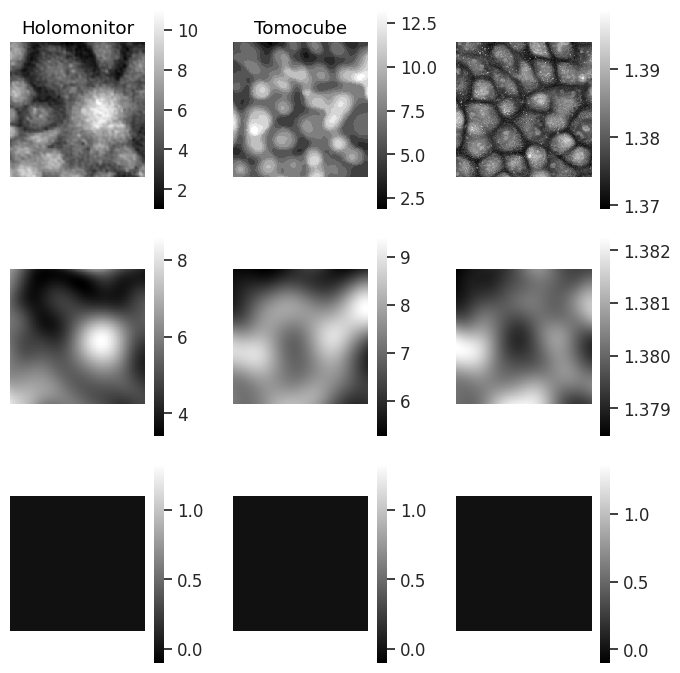

In [10]:
fig, ax = plt.subplots(3, 3, figsize=(7, 7))
sns.set_theme(style='ticks', palette='deep', font_scale=1.1)

ax[0,0].set(title="Holomonitor")
ax[0,1].set(title="Tomocube")

sns.heatmap(im_h_holo[0], ax=ax[0,0], square=True, cmap="gray", xticklabels=False, yticklabels=False)
sns.heatmap(im_h_tomo[0], ax=ax[0,1], square=True, cmap="gray", xticklabels=False, yticklabels=False)
sns.heatmap(im_n_tomo[0], ax=ax[0,2], square=True, cmap="gray", xticklabels=False, yticklabels=False)

sns.heatmap(im_hblur_holo[0], ax=ax[1,0], square=True, cmap="gray", xticklabels=False, yticklabels=False)
sns.heatmap(im_hblur_tomo[0], ax=ax[1,1], square=True, cmap="gray", xticklabels=False, yticklabels=False)
sns.heatmap(im_nblur_tomo[0], ax=ax[1,2], square=True, cmap="gray", xticklabels=False, yticklabels=False)

sns.heatmap((areas_holo[0] == 0)*im_h_holo[0], ax=ax[2,0], cmap="gray", square=True, xticklabels=False, yticklabels=False, vmin=1.33)
sns.heatmap((areas_tomo[0] == 0)*im_h_tomo[0], ax=ax[2,1], cmap="gray", square=True, xticklabels=False, yticklabels=False, vmin=1.33)
sns.heatmap((areas_tomo[0] == 0)*im_n_tomo[0], ax=ax[2,2], cmap="gray", square=True, xticklabels=False, yticklabels=False, vmin=1.37)

fig.tight_layout()
#fig.savefig("")

In [14]:
cellwise_heigts = np.copy(areas_tomo[0])
heights = []

for l in np.unique(cellwise_heigts):
    mask = cellwise_heigts == l
    df_mask = df_tomo[0].label==l
    cellwise_heigts[mask] = df_tomo[0][df_mask].h_avrg.values[0]
    heights.append(df_tomo[0][df_mask].h_avrg.values[0])

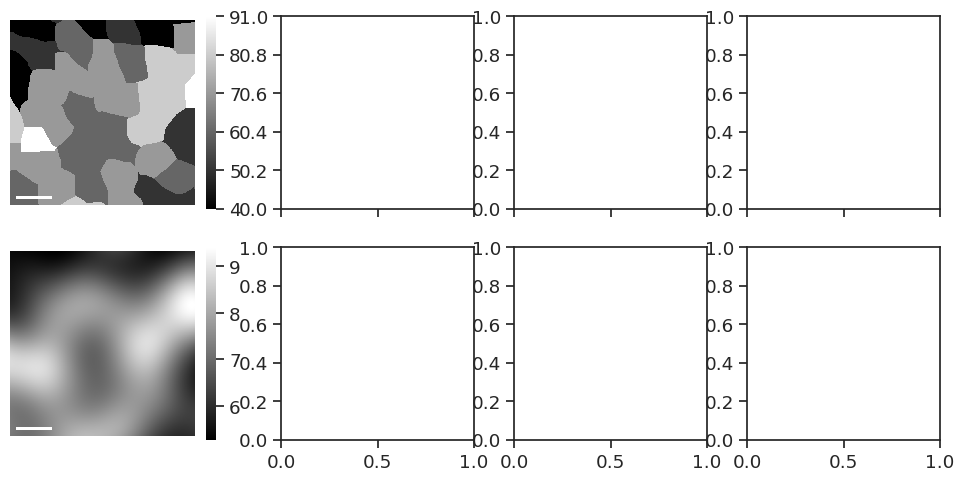

In [19]:
color  = "darkblue"
lcolor = "magenta"
e_cmap = mpl.colors.ListedColormap(['none', 'w'])
sns.set_theme(style='ticks', palette='muted', font_scale=1.2)
fig, ax = plt.subplots(2, 4, figsize=(12, 5.5), sharex="col", sharey="col", gridspec_kw={"width_ratios":[1.2, 1, 1, 1]})

# prepare cellwise illustation
im_cells = (scikit.segmentation.clear_border(areas_tomo[0]) > 0)
im_cells = im_n_tomo[0]*im_cells
im_cells[im_cells == 0] = np.nan

im_c = sns.heatmap(cellwise_heigts, ax=ax[0,0],  cmap="gray", square=True, xticklabels=False, yticklabels=False, cbar=True)
im_d = sns.heatmap(im_hblur_tomo[0], ax=ax[1,0], cmap="gray", square=True, xticklabels=False, yticklabels=False, cbar=True)

for i, c in zip(range(2), ["w", "w"]):
    sb = ScaleBar(vox_to_um[2], 'um', box_alpha=0, color=c, height_fraction=2e-2, scale_loc="none", fixed_value=20)
    sb.location = 'lower left'
    ax[i,0].add_artist(sb)

In [20]:
hmin, hmax = 1, 15.5
nmin, nmax = 1.368, 1.393375
bins = 30

# compute mean distributions
hcell_holo = [df.h_avrg.values for df in df_holo]
hcell_tomo = [df.h_avrg.values for df in df_tomo]
ncell_tomo = [df.n_avrg.values for df in df_tomo]

x_holo,  h_holo_hist, h_holo_err = mean_dist(hcell_holo, bins=bins, hist_range=(hmin, hmax))
x_tomo,  h_tomo_hist, h_tomo_err = mean_dist(hcell_tomo, bins=bins, hist_range=(hmin, hmax))
nx_tomo, n_tomo_hist, n_tomo_err = mean_dist(ncell_tomo, bins=bins, hist_range=(nmin, nmax))

# compute mean and std
h_holo_mean = np.mean(np.concatenate(hcell_holo))
h_tomo_mean = np.mean(np.concatenate(hcell_tomo))
n_tomo_mean = np.mean(np.concatenate(ncell_tomo))

h_holo_std = np.std(np.concatenate(hcell_holo))
h_tomo_std = np.std(np.concatenate(hcell_tomo))
n_tomo_std = np.std(np.concatenate(ncell_tomo))

print("Cell data")
print(f"Holomonitor heights = {h_holo_mean:0.2f}, {h_holo_std:0.2f}")
print(f"Tomocube heights    = {h_tomo_mean:0.2f}, {h_tomo_std:0.2f}")
print(f"Tomocube refractive index = {n_tomo_mean:0.3f}, {n_tomo_std:0.3f}")
n_tomo_std

Array lenght is: 7
Array lenght is: 2
Array lenght is: 2
Cell data
Holomonitor heights = 6.05, 1.82
Tomocube heights    = 7.27, 1.57
Tomocube refractive index = 1.380, 0.001


0.0014211197857883463

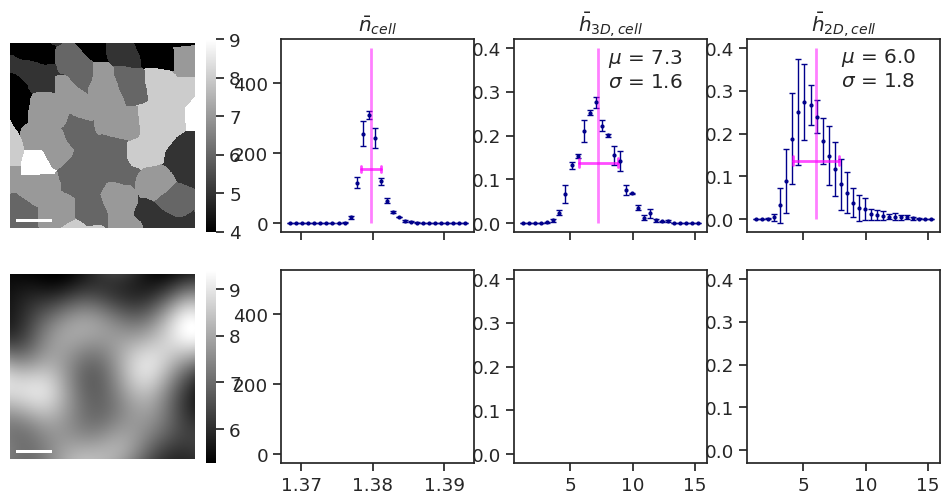

In [21]:
lw=1
ms=4

ax[0,3].errorbar(x_holo,  h_holo_hist, yerr=h_holo_err, fmt=".", lw=lw, ms=ms, capsize=2, capthick=1, color=color)
ax[0,2].errorbar(x_tomo,  h_tomo_hist, yerr=h_tomo_err, fmt=".", lw=lw, ms=ms, capsize=2, capthick=1, color=color)
ax[0,1].errorbar(nx_tomo, n_tomo_hist, yerr=n_tomo_err, fmt=".", lw=lw, ms=ms, capsize=2, capthick=1, color=color)

lw = 2
alpha = 0.5

ax[0,3].vlines(h_holo_mean, 0, 4e-1, alpha=alpha, lw=lw, color=lcolor)
ax[0,2].vlines(h_tomo_mean, 0, 4e-1, alpha=alpha, lw=lw, color=lcolor)
ax[0,1].vlines(n_tomo_mean, 0, 5e2,  alpha=alpha, lw=lw, color=lcolor)

fwhm = h_holo_hist.max() / 2
ax[0,3].text(8, 0.31, f"$\mu$ = {h_holo_mean:0.1f}\n$\sigma$ = {h_holo_std:0.1f}")
ax[0,3].plot([h_holo_mean-h_holo_std, h_holo_mean+h_holo_std], [fwhm, fwhm],           lw=lw, color=lcolor, alpha=0.7)
ax[0,3].plot([h_holo_mean-h_holo_std, h_holo_mean-h_holo_std], [fwhm-0.01, fwhm+0.01], lw=lw, color=lcolor, alpha=0.7)
ax[0,3].plot([h_holo_mean+h_holo_std, h_holo_mean+h_holo_std], [fwhm-0.01, fwhm+0.01], lw=lw, color=lcolor, alpha=0.7)

fwhm = h_tomo_hist.max() / 2
ax[0,2].text(8, 0.31, f"$\mu$ = {h_tomo_mean:0.1f}\n$\sigma$ = {h_tomo_std:0.1f}")
ax[0,2].plot([h_tomo_mean-h_tomo_std, h_tomo_mean+h_tomo_std], [fwhm, fwhm],           lw=lw, color=lcolor, alpha=0.7)
ax[0,2].plot([h_tomo_mean-h_tomo_std, h_tomo_mean-h_tomo_std], [fwhm-0.01, fwhm+0.01], lw=lw, color=lcolor, alpha=0.7)
ax[0,2].plot([h_tomo_mean+h_tomo_std, h_tomo_mean+h_tomo_std], [fwhm-0.01, fwhm+0.01], lw=lw, color=lcolor, alpha=0.7)

fwhm = n_tomo_hist.max() / 2
#ax[0,1].text(1.381, 450, rf"$\sigma = 10^{{-3}}$") #{n_tomo_std:0.3f}")
ax[0,1].plot([n_tomo_mean-n_tomo_std, n_tomo_mean+n_tomo_std], [fwhm, fwhm],     lw=lw, color=lcolor, alpha=0.7)
ax[0,1].plot([n_tomo_mean-n_tomo_std, n_tomo_mean-n_tomo_std], [fwhm-8, fwhm+8], lw=lw, color=lcolor, alpha=0.7)
ax[0,1].plot([n_tomo_mean+n_tomo_std, n_tomo_mean+n_tomo_std], [fwhm-8, fwhm+8], lw=lw, color=lcolor, alpha=0.7)


# ax[0,3].set(xlabel=r"$\bar{h}_{2D, cell}$ [µm]")#, ylim=(1e-6, 1.5e0))
# ax[0,2].set(xlabel=r"$\bar{h}_{3D, cell}$ [µm]")#, ylim=(1e-6, 1.5e0))
# ax[0,1].set(xlabel=r"$\bar{n}_{cell}$")#, ylim=(1e-1, 1e3))

ax[0,3].set(title=r"$\bar{h}_{2D, cell}$")#, ylim=(1e-6, 1.5e0))
ax[0,2].set(title=r"$\bar{h}_{3D, cell}$")#, ylim=(1e-6, 1.5e0))
ax[0,1].set(title=r"$\bar{n}_{cell}$")#, ylim=(1e-1, 1e3))

fig

In [22]:
# compute mean distributions
x_holo,  h_holo_hist, h_holo_err = mean_dist(hblur_holo, bins=bins, hist_range=(hmin, hmax))
x_tomo,  h_tomo_hist, h_tomo_err = mean_dist(hblur_tomo, bins=bins, hist_range=(hmin, hmax))
nx_tomo, n_tomo_hist, n_tomo_err = mean_dist(nblur_tomo, bins=bins, hist_range=(nmin, nmax))

# compute mean and std
h_holo_mean = np.mean(hblur_holo[h_holo>0])
h_tomo_mean = np.mean(hblur_tomo[h_tomo>0])
n_tomo_mean = np.mean(nblur_tomo[h_tomo>0])

h_holo_std = np.std(hblur_holo[h_holo>0])
h_tomo_std = np.std(hblur_tomo[h_tomo>0])
n_tomo_std = np.std(nblur_tomo[h_tomo>0])

print("Blurred data")
print(f"Holomonitor heights = {h_holo_mean:0.2f}, {h_holo_std:0.2f}")
print(f"Tomocube heights    = {h_tomo_mean:0.2f}, {h_tomo_std:0.2f}")
print(f"Tomocube refractive index = {n_tomo_mean:0.3f}, {n_tomo_std:0.3f}")

Array lenght is: 7
Array lenght is: 2
Array lenght is: 2
Blurred data
Holomonitor heights = 5.91, 1.63
Tomocube heights    = 7.53, 1.53
Tomocube refractive index = 1.380, 0.001


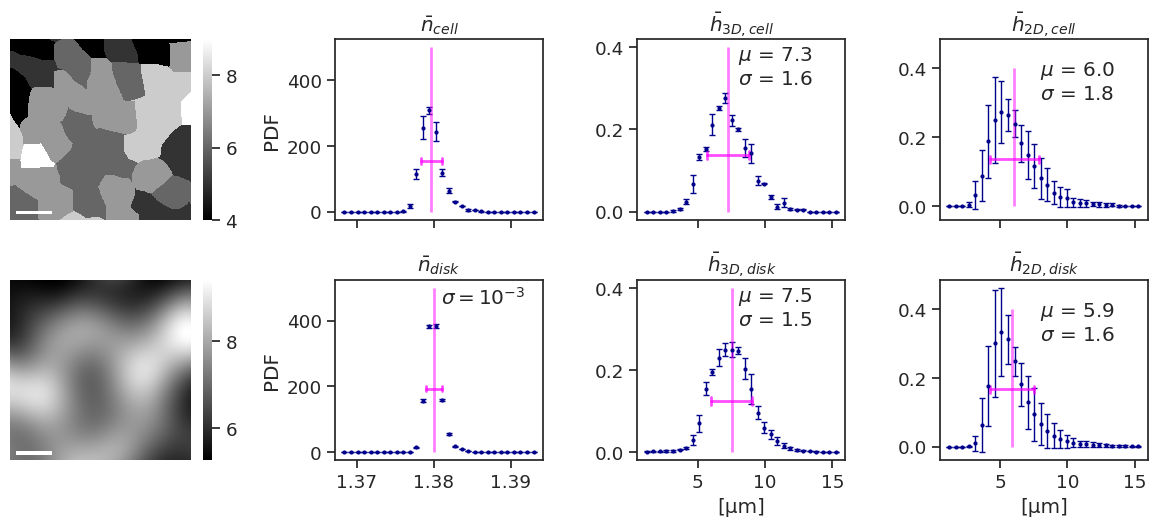

In [23]:
lw = 1
ms = 4

ax[1,3].errorbar(x_holo,  h_holo_hist, yerr=h_holo_err, fmt=".", lw=lw, ms=ms, capsize=2, capthick=1, color=color)
ax[1,2].errorbar(x_tomo,  h_tomo_hist, yerr=h_tomo_err, fmt=".", lw=lw, ms=ms, capsize=2, capthick=1, color=color)
ax[1,1].errorbar(nx_tomo, n_tomo_hist, yerr=n_tomo_err, fmt=".", lw=lw, ms=ms, capsize=2, capthick=1, color=color)

lw = 2
alpha = 0.5

ax[1,3].vlines(h_holo_mean, 0, 4e-1, alpha=alpha, lw=lw, color=lcolor)
ax[1,2].vlines(h_tomo_mean, 0, 4e-1, alpha=alpha, lw=lw, color=lcolor)
ax[1,1].vlines(n_tomo_mean, 0, 5e2,  alpha=alpha, lw=lw, color=lcolor)


fwhm = h_holo_hist.max() / 2
ax[1,3].text(8, 0.31, f"$\mu$ = {h_holo_mean:0.1f}\n$\sigma$ = {h_holo_std:0.1f}")
ax[1,3].plot([h_holo_mean-h_holo_std, h_holo_mean+h_holo_std], [fwhm, fwhm],           lw=lw, color=lcolor, alpha=0.7)
ax[1,3].plot([h_holo_mean-h_holo_std, h_holo_mean-h_holo_std], [fwhm-0.01, fwhm+0.01], lw=lw, color=lcolor, alpha=0.7)
ax[1,3].plot([h_holo_mean+h_holo_std, h_holo_mean+h_holo_std], [fwhm-0.01, fwhm+0.01], lw=lw, color=lcolor, alpha=0.7)

fwhm = h_tomo_hist.max() / 2
ax[1,2].text(8, 0.31, f"$\mu$ = {h_tomo_mean:0.1f}\n$\sigma$ = {h_tomo_std:0.1f}")
ax[1,2].plot([h_tomo_mean-h_tomo_std, h_tomo_mean+h_tomo_std], [fwhm, fwhm],           lw=lw, color=lcolor, alpha=0.7)
ax[1,2].plot([h_tomo_mean-h_tomo_std, h_tomo_mean-h_tomo_std], [fwhm-0.01, fwhm+0.01], lw=lw, color=lcolor, alpha=0.7)
ax[1,2].plot([h_tomo_mean+h_tomo_std, h_tomo_mean+h_tomo_std], [fwhm-0.01, fwhm+0.01], lw=lw, color=lcolor, alpha=0.7)

fwhm = n_tomo_hist.max() / 2
ax[1,1].text(1.381, 450, rf"$\sigma = 10^{{-3}}$") #{n_tomo_std:0.3f}")
ax[1,1].plot([n_tomo_mean-n_tomo_std, n_tomo_mean+n_tomo_std], [fwhm, fwhm],           lw=lw, color=lcolor, alpha=0.7)
ax[1,1].plot([n_tomo_mean-n_tomo_std, n_tomo_mean-n_tomo_std], [fwhm-8, fwhm+8], lw=lw, color=lcolor, alpha=0.7)
ax[1,1].plot([n_tomo_mean+n_tomo_std, n_tomo_mean+n_tomo_std], [fwhm-8, fwhm+8], lw=lw, color=lcolor, alpha=0.7)


# ax[1,3].set(xlabel=fr"$h_{{2D}}({rblur_holo}r_{{cell}};x,y)$ [µm]")
# ax[1,2].set(xlabel=fr"$h_{{3D}}({rblur_tomo}r_{{cell}};x,y)$ [µm]")
# ax[1,1].set(xlabel=fr"$\bar{{n}}_{{z}}({rblur_tomo}r_{{cell}};x,y)$")

# set title
ax[1,3].set(title=fr"$\bar{{h}}_{{2D, disk}}$")#({rblur_holo}r_{{cell}})$")
ax[1,2].set(title=fr"$\bar{{h}}_{{3D, disk}}$")#({rblur_tomo}r_{{cell}})$")
ax[1,1].set(title=fr"$\bar{{n}}_{{disk}}$")#({rblur_tomo}r_{{cell}})$")

ax[0,1].set(ylabel="PDF")
ax[1,1].set(ylabel="PDF")#, xlabel="h [µm]")
ax[1,2].set(xlabel="[µm]")
ax[1,3].set(xlabel="[µm]")


fig.tight_layout()
fig

In [24]:
fig.savefig(f"../../figs/illustrations/cellwise_illustration_text.png", dpi=300)